# JPEG Compression

1. [Colorspace Conversion](#yuv)


2. [Chroma Subsampling](#subs)


3. [DCT and Quantization](#dct)


4. [Delta & Huffman Encoding](#enc)


Good links:
- [Understanding and writing JPEG decoder in python](https://yasoob.me/posts/understanding-and-writing-jpeg-decoder-in-python/)
- [Understanding Image Compression](https://medium.com/big-on-development/understanding-image-compression-362087124136)

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Colorspace Conversion <a id='yuv'></a>

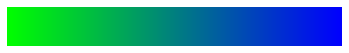

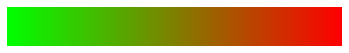

In [4]:
def show_image(image, bgr=True):
    plt.axis('off')
    if bgr:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    
colormap_u = np.array([[[i,255-i,0] for i in range(256)]],dtype=np.uint8)
colormap_v = np.array([[[0,255-i,i] for i in range(256)]],dtype=np.uint8)

show_image(np.concatenate([colormap_u]*30, axis=0))
show_image(np.concatenate([colormap_v]*30, axis=0))


### Test image

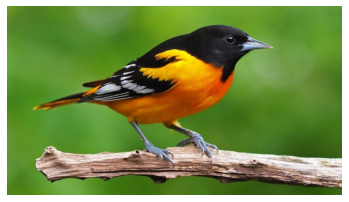

In [5]:
im = cv2.imread('plots/bird.jpg')
show_image(im)

### Chroma map

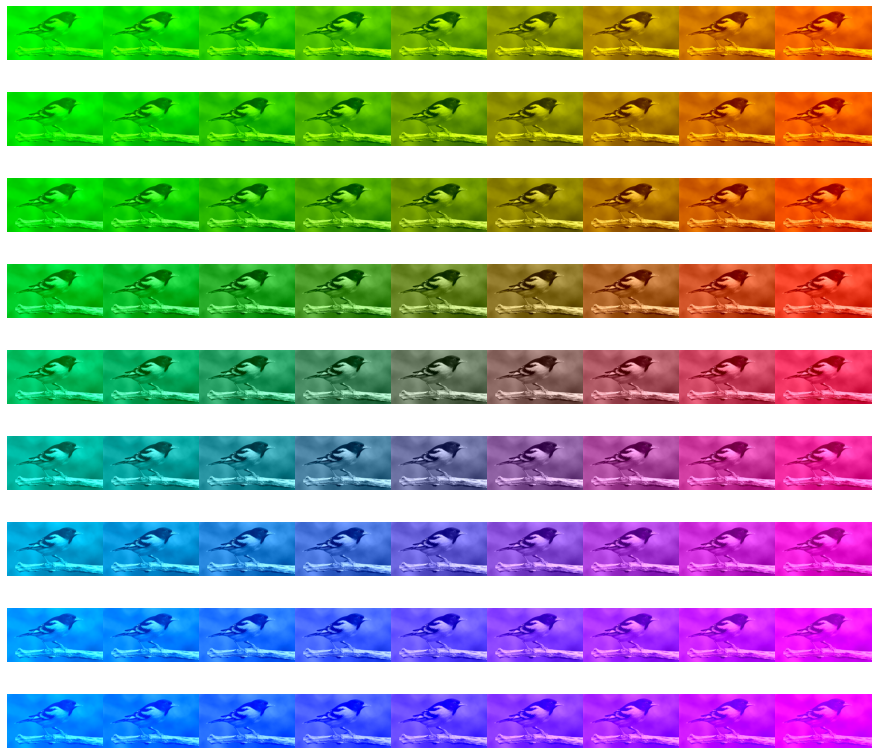

In [260]:
offsets = [0,30, 60, 90, 120, 150, 180, 210, 240]
f, ax = plt.subplots(len(offsets), len(offsets),figsize=(12,12))
f.tight_layout(pad=0)


for i1, d1 in enumerate(offsets):
    for i2, d2 in enumerate(offsets):
        yuvim = np.stack([y, 
                          d1 + np.zeros(u.shape), 
                          d2 + np.zeros(v.shape)], axis=2).astype('uint8')
    
        rgbim = cv2.cvtColor(yuvim, cv2.COLOR_YUV2RGB)
        ax[i1, i2].imshow(rgbim)
        ax[i1, i2].axis('off')
        f.tight_layout(pad=0)


### Changes in luminosity

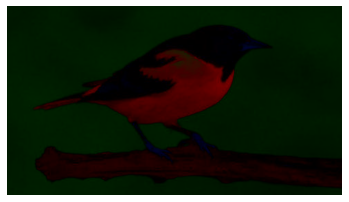

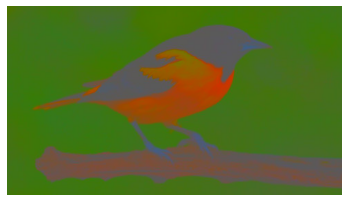

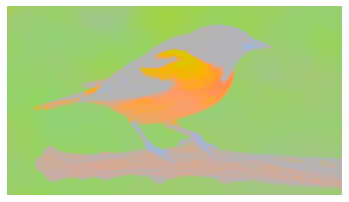

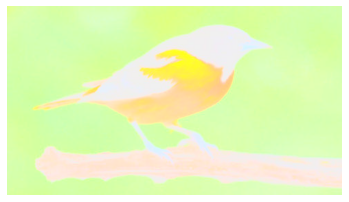

In [265]:
for delta in [0, 90, 180, 240]:
    yuvim = np.stack([delta + np.zeros(y.shape), 
                      u, 
                      v], axis=2).astype('uint8')

    rgbim = cv2.cvtColor(yuvim, cv2.COLOR_YUV2RGB)
    show_image(rgbim, False)

# Chroma Subsampling <a id='subs'></a>

Humans are a lot better at distingushing changes in brightness than changes in color. Subsample color in the following way: given a `2 x J` block, a `J:a:b` subsample means that we take `J` values of luma per row, `a` unique chroma values in row `1` and `b` chroma values in row `2`


![](plots/subs.png)

And this [good video](https://www.youtube.com/watch?v=fkz2-JVaYDk) with some more explanation. If we choose `4:4:4` then no subsampling occurs.

# Discrete Cosine Transform & Quantization <a id='dct'></a>

The following DCT explanation is only shown for the brightness values. A similar approached is used to quantize the chroma, although with different (and more strict) quantization matrices.

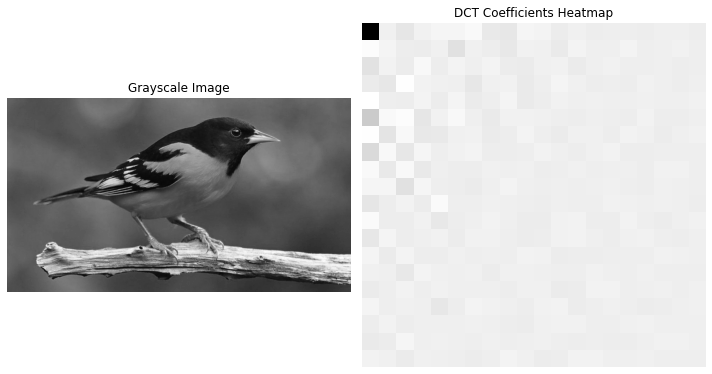

In [6]:
raw_im = (im.mean(2)/255.0).astype('float32')
dct_coef = cv2.dct(raw_im)

f, ax = plt.subplots(1,2, figsize=(10,7))

ax[0].axis('off'); ax[1].axis('off')

ax[0].imshow(raw_im, cmap='gray')
ax[0].set_title('Grayscale Image')

ax[1].imshow(dct_coef[:20, :20], cmap='binary')
ax[1].set_title('DCT Coefficients Heatmap')

plt.tight_layout()


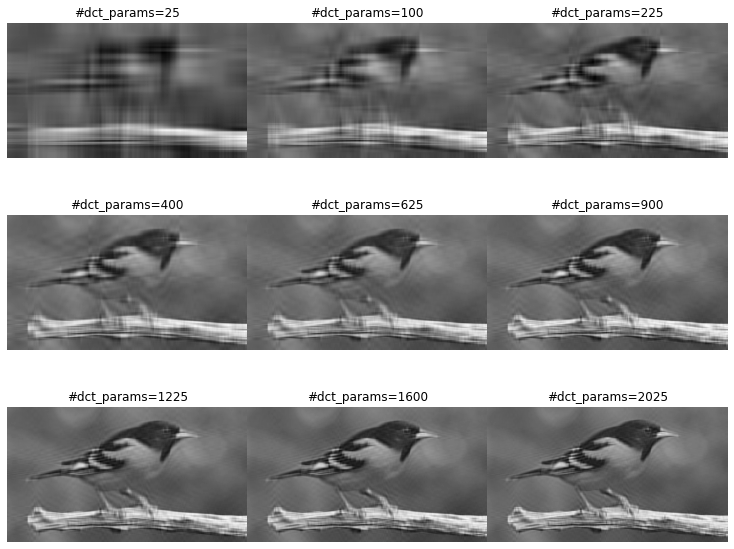

In [7]:

f, ax = plt.subplots(3, 3, figsize=(10,10))

for i, d in enumerate(range(5, 50, 5)):
    iter_dct = dct_coef.copy()
    iter_dct[d:, d:] = 0
    ax[i//3, i%3].imshow( cv2.idct( iter_dct ), cmap='gray')
    ax[i//3, i%3].set_title('#dct_params=%d'%(d**2))
    ax[i//3, i%3].axis('off')
    f.tight_layout(pad=0)
    
plt.show()
    

In JPEG, DCT is applied to `8x8` pixel blocks separately. This means that after applying DCT to an `8x8` block, we will get an `8x8` weight matrix, corresponding to the following 64 cosine functions:

![](plots/dct64.png)


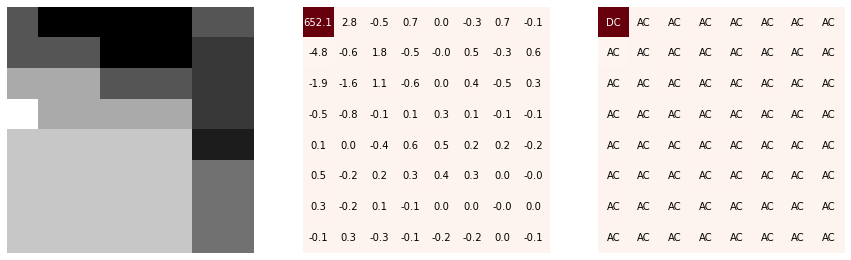

In [14]:
f, ax = plt.subplots(1, 3, figsize=(15, 8))

p = (60, 90)

block = raw_im[p[0]:p[0]+8:, p[1]:p[1]+8].copy()*255
dct_block = cv2.dct(block)

ax[0].imshow(block, cmap='gray')

ax[1].matshow(dct_block, cmap='Reds')
ax[2].matshow(dct_block, cmap='Reds')

for i in range(3): ax[i].axis('off')

for i in range(8):
    for j in range(8):
        color = 'white' if i+j == 0 else 'black'
        c = dct_block[j,i].round(1)
        ax[1].text(i, j, str(c), va='center', ha='center', c=color)
        ax[2].text(i, j, 'DC' if i+j == 0 else 'AC', va='center', ha='center', c=color)


The top left (dark red) coefficient is called the DC, while the rest are AC values.

The quantization part comes from dividing the dct coefficients element-wise by a quantization matrix, for example:

![](plots/quant.png)

The intuition being that high frequency coefficients will be rounded to zero, and lower frequency ones will be scaled by less (there might have to be clamping applied to ensure values fall inside of `[0, 255]`).

This is then reshaped into a 1D vector using a zig-zag pattern from left to right (so the array moves from lowest to highest frquency weights from start to end).

# Delta & Huffman Encoding <a id='enc'></a>

## Delta encoding

In delta encoding, the sequence `[10, 11, 12, 13, 10, 9]` becomes `[10, 1, 2, 3, 0, -1]`. In JPEG, each DC value of an `8x8` block is delta encoded relative to the previous block. This keeps the DC values around 0 which is useful for Huffman encoding.

## Huffman Encoding
Huffman encoding is the lossless minimum number of bits that it takes to encode an arbitrary number of values.


The general idea is to create a mapping of all the unique values in the message you want to encode such that the most used characters map to the lowest bit representation. For example:

Given `abacdeab`, we can represent characters as bytes as:

```
a: 01100001
b: 01100010
c: 01100011
d: 01100100
e: 01100101
```

This will give us `0110000101100010011000010110001101100100011001010110000101100010`, with `8x8=64` bits to encode the message. But can we encode the message using a more efficient representation? Yes, for example:

```
a: 000
b: 001
c: 010
d: 100
e: 011
```

Which will give `000001000010100011000001`, with `3x8=24` bits to encode. But we can use even less, in fact the least number of bits for lossless compression corresponds to the mapping:

```
a: 0
b: 1
c: 00
d: 01
e: 10
```

And the `8` character message is encoded as `01000011001` with `11` bits.

Finding these mappings is done by using Huffman Trees ([blogpost](https://www.techiedelight.com/huffman-coding/), [video](https://www.youtube.com/watch?v=dM6us854Jk0) of the step by step, more general [video walkthrough](https://www.youtube.com/watch?v=JsTptu56GM8)). This basically involves building a binary tree bottom up starting with the least frequent characters.

As far as JPEG, we store the DCT coefficients using Huffman encoding (the idea being that the delta encoding will distribute the DC values around 0 and help with the vocabulary size, and therefore a more efficient Huffman encoding). JPEG will in fact store in its header up to 4 Huffman Trees: Brightness DC values, brightness AC values, chroma DC values, and chroma AC values (not separated by channel).
